In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn

from multiprocessing import Pool


sys.path.append("../functions")

from Utility import *
from Plotting import *
from Forward import *
from Backward import *

In [206]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]

chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]

subjects = lv_induction_data["sub"].unique()
alpha_list = np.linspace(.05,1,100)

In [207]:
def add_noise_to_conf(confs, scale):
    confs_cloned = confs.copy()
    noises =  np.random.normal(loc=0.0, scale=scale, size= len(confs))
    confs_cloned += noises
    confs_cloned[confs_cloned > 5] = 5
    confs_cloned[confs_cloned <1] = 1
    return confs_cloned

In [210]:
def learning_effect(alpha, beta):
    
    lbound = 1
    hbound = 5
    params = [alpha, beta, lbound, hbound]
    
    trials_info = get_subject_task(lv_induction_data, subjects[0])
    params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]

    resps, rewards, acc, confs, Q_list = simulate_agent(params, trials_info)
    df = pd.DataFrame(zip(resps, rewards, acc, confs, Q_list[:, 0], Q_list[:, 1]),
                      columns=["resp", "reward", "cor", "cj", "Q1", "Q2"])
    d = {"resps" : resps,
        "rewards": rewards,
        "confs": confs,
        "n_fitting":60,
        "params_ranges": params_ranges}

    forward_params, forward_neg_LL_seq, forward_dist_seq = forward_fitting(d)
    backward_params, backward_neg_LL_seq, backward_dist_seq = backward_fitting(d)
    
    n_simulate = 30
    forward_perf = np.zeros(n_simulate)
    backward_perf = np.zeros(n_simulate)
    backward_perf1 = np.zeros(n_simulate)
    backward_perf2 = np.zeros(n_simulate)
    backward_perf3 = np.zeros(n_simulate)
    for i in range(n_simulate):
        
        d["confs"] = add_noise_to_conf(confs, 1)
        backward_params1, backward_neg_LL_seq1, backward_dist_seq1 = backward_fitting(d)
        d["confs"] = add_noise_to_conf(confs, 2)
        backward_params2, backward_neg_LL_seq2, backward_dist_seq2 = backward_fitting(d)
        d["confs"] = add_noise_to_conf(confs, 3)
        backward_params3, backward_neg_LL_seq3, backward_dist_seq3 = backward_fitting(d)
        
        resps, rewards, acc, cj, Q_list = simulate_agent(forward_params, trials_info)
        forward_perf[i] = np.mean(acc)
        resps, rewards, acc, cj, Q_list = simulate_agent(backward_params, trials_info)
        backward_perf[i] = np.mean(acc)
        resps, rewards, acc, cj, Q_list = simulate_agent(backward_params1, trials_info)
        backward_perf1[i] = np.mean(acc)
        resps, rewards, acc, cj, Q_list = simulate_agent(backward_params2, trials_info)
        backward_perf2[i] = np.mean(acc)
        resps, rewards, acc, cj, Q_list = simulate_agent(backward_params3, trials_info)
        backward_perf3[i] = np.mean(acc)

    forward_perf_mean = np.mean(forward_perf)
    backward_perf_mean = np.mean(backward_perf)
    backward_perf_mean1 = np.mean(backward_perf1)
    backward_perf_mean2 = np.mean(backward_perf2)
    backward_perf_mean3 = np.mean(backward_perf3)
    qsr = group_qsr(df)
    return forward_perf_mean, backward_perf_mean, backward_perf_mean1, backward_perf_mean2, backward_perf_mean3, qsr

In [211]:
from functools import partial
betas = [5, 15, 40]
n_threads = 100
results_list = []
for beta in betas:
    f_part = partial(learning_effect, beta= beta)
    with Pool(n_threads) as p:
        result = np.array(p.map(f_part, alpha_list))
    results_list.append(result)

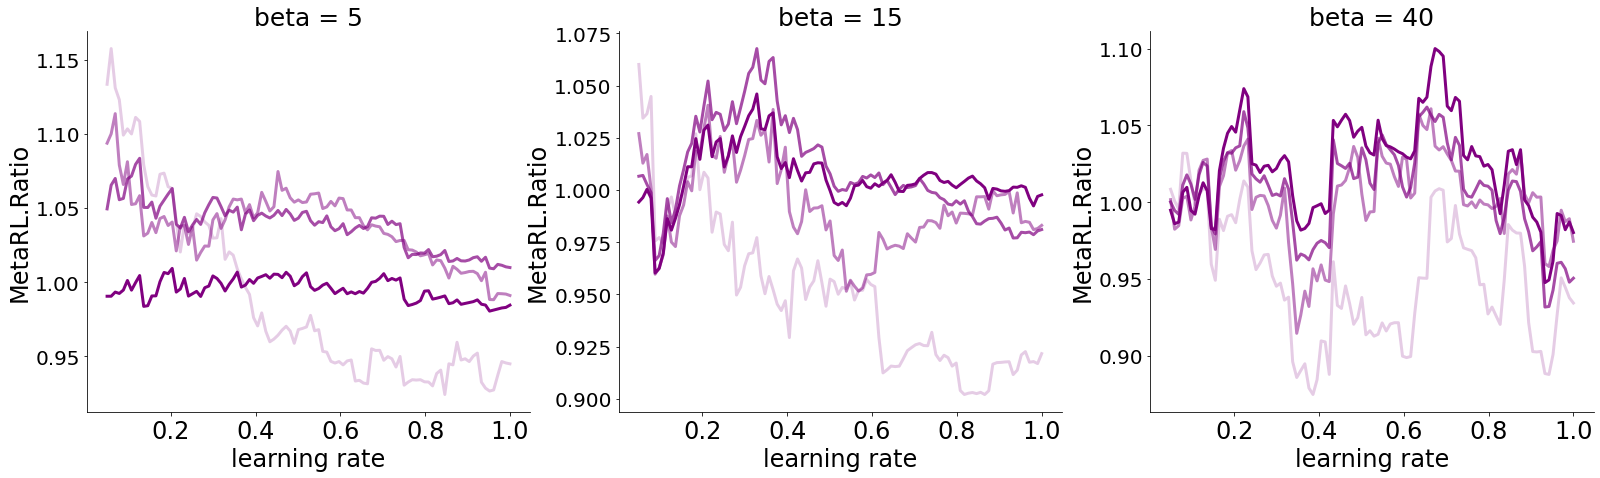

In [212]:
plt.figure(figsize=(27, 7))

for i,result in enumerate(results_list):
    forward_perf = result[:,0]
    backward_perf = result[:,1]
    backward_perf1 = result[:,2]
    backward_perf2 = result[:,3]
    backward_perf3 = result[:,4]
    
    mrl = backward_perf/forward_perf
    mrl1 = backward_perf1/forward_perf
    mrl2 = backward_perf2/forward_perf
    mrl3 = backward_perf3/forward_perf
    
    plt.subplot(1, 3, i+1)
    
    plt.plot(alpha_list, mrl, color = "purple", lw = 3 , label = "Meta.RL ")
    plt.plot(alpha_list, mrl1, color = "purple", lw = 3, alpha = .7 , label = "noise_std = 1")
    plt.plot(alpha_list, mrl2, color = "purple", lw = 3,alpha = .5, label = "noise_std = 2")
    plt.plot(alpha_list, mrl3, color = "purple", lw = 3,alpha = .2,label = "noise_std = 3")
    
    plt.title("beta = {}".format(betas[i]) , fontsize=25)
    
    plt.xlabel("learning rate", fontsize=24)
    plt.ylabel("MetaRL.Ratio", fontsize=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=24)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

In [202]:
beta_list = np.linspace(1,100,100)   
alphas = [.2, .6, .9]
beta_results_list = []
for alpha in alphas:
    f_part = partial(beta_effect, alpha= alpha)
    with Pool(n_threads) as p:
        result = np.array(p.map(f_part, beta_list))
    beta_results_list.append(result)

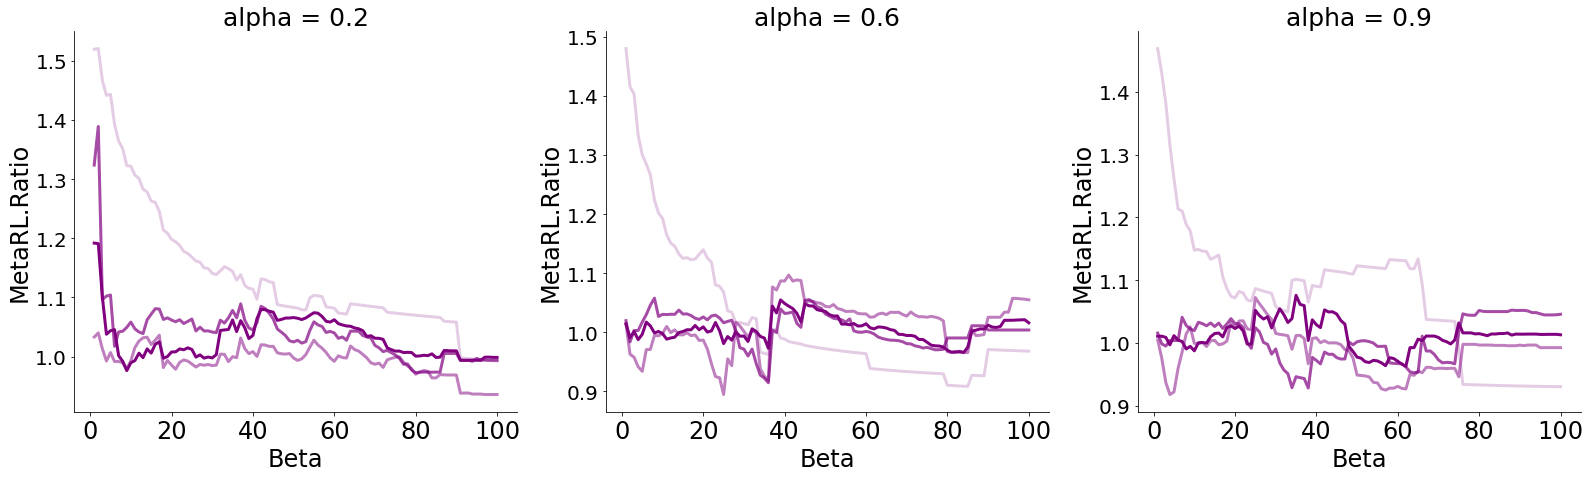

In [204]:
plt.figure(figsize=(27, 7))

for i,result in enumerate(beta_results_list):
    
    forward_perf = result[:,0]
    backward_perf = result[:,1]
    backward_perf1 = result[:,2]
    backward_perf2 = result[:,3]
    backward_perf3 = result[:,4]
    
    mrl = backward_perf/forward_perf
    mrl1 = backward_perf1/forward_perf
    mrl2 = backward_perf2/forward_perf
    mrl3 = backward_perf3/forward_perf
    
    plt.subplot(1, 3, i+1)
    
    plt.plot(beta_list, mrl, color = "purple", lw = 3 , label = "Meta.RL ")
    plt.plot(beta_list, mrl1, color = "purple", lw = 3, alpha = .7 , label = "noise_std = 1")
    plt.plot(beta_list, mrl2, color = "purple", lw = 3,alpha = .5, label = "noise_std = 2")
    plt.plot(beta_list, mrl3, color = "purple", lw = 3,alpha = .2,label = "noise_std = 3")
    
    plt.title("alpha = {}".format(alphas[i]) , fontsize=25)
    
    plt.xlabel("Beta", fontsize=24)
    plt.ylabel("MetaRL.Ratio", fontsize=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=24)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

In [184]:
forward_perf = result[:,0]
backward_perf = result[:,1]
backward_perf1 = result[:,2]
backward_perf2 = result[:,3]
backward_perf3 = result[:,4]
qsr = result[:,5]

In [151]:
mrl1 = backward_perf1/forward_perf
mrl2 = backward_perf2/forward_perf
mrl3 = backward_perf3/forward_perf

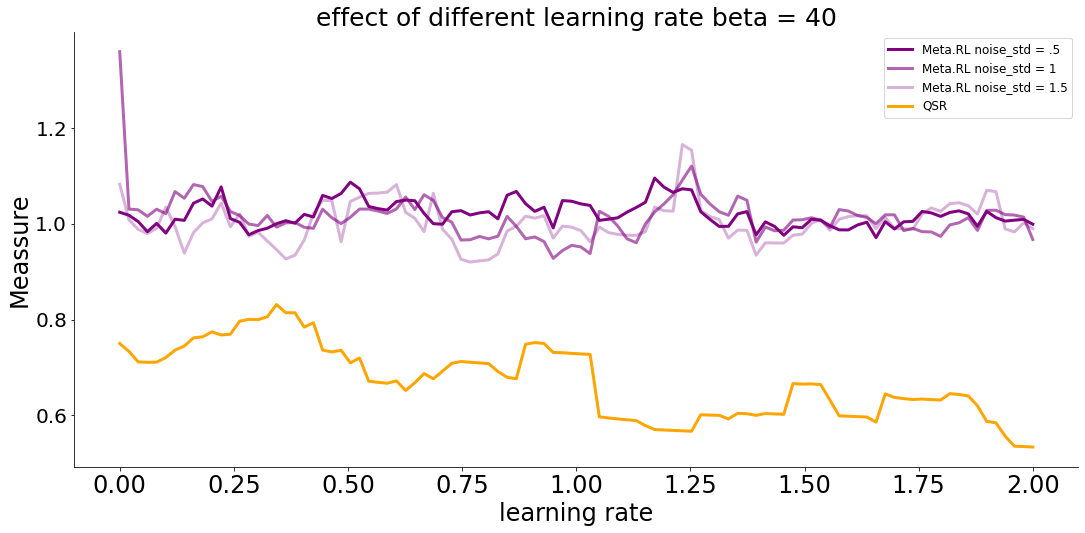

In [152]:
fig, ax = plt.subplots(figsize = (18,8) )

ax.plot(alpha_list, mrl1, color = "purple", lw = 3 , label = "Meta.RL noise_std = .5")
ax.plot(alpha_list, mrl2, color = "purple", lw = 3,alpha = .6, label = "Meta.RL noise_std = 1")
ax.plot(alpha_list, mrl3, color = "purple", lw = 3,alpha = .3,label = "Meta.RL noise_std = 1.5")
ax.plot(alpha_list, qsr, color = "orange",label = "QSR" , lw = 3)

plt.title("effect of different learning rate beta = 40" , fontsize=25)
plt.xlabel("learning rate", fontsize=24)
plt.ylabel("Meassure", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=12)
plt.show()

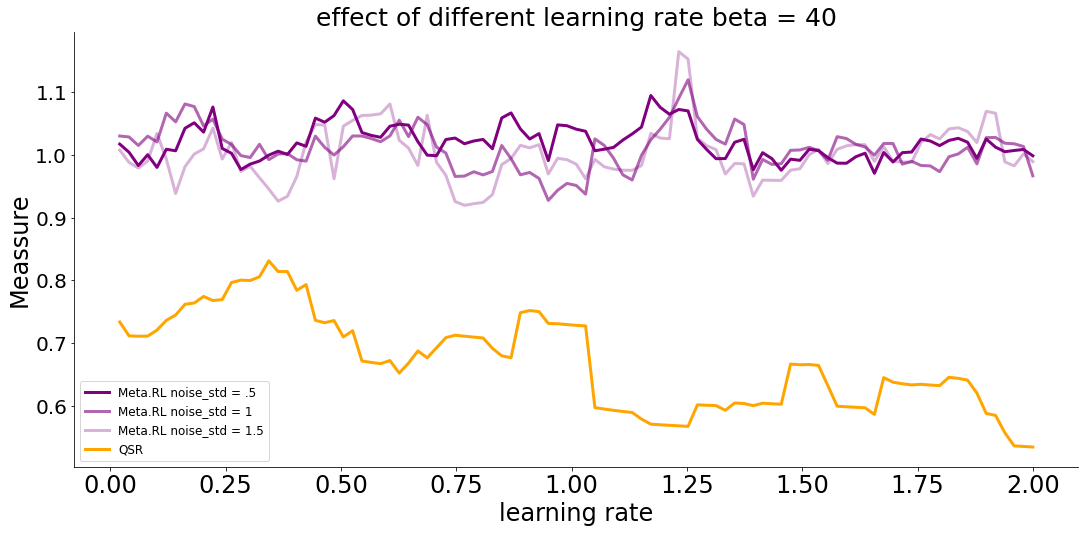

In [153]:
fig, ax = plt.subplots(figsize = (18,8) )

ax.plot(alpha_list[1:], mrl1[1:], color = "purple", lw = 3 , label = "Meta.RL noise_std = .5")
ax.plot(alpha_list[1:], mrl2[1:], color = "purple", lw = 3,alpha = .6, label = "Meta.RL noise_std = 1")
ax.plot(alpha_list[1:], mrl3[1:], color = "purple", lw = 3,alpha = .3,label = "Meta.RL noise_std = 1.5")
ax.plot(alpha_list[1:], qsr[1:], color = "orange",label = "QSR" , lw = 3)

plt.title("effect of different learning rate beta = 40" , fontsize=25)
plt.xlabel("learning rate", fontsize=24)
plt.ylabel("Meassure", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=12)
plt.show()

## Beta Effect

In [201]:
def beta_effect(beta, alpha):
    
    lbound = 1
    hbound = 5
    params = [alpha, beta, lbound, hbound]
    
    trials_info = get_subject_task(lv_induction_data, subjects[0])
    params_ranges = [[0, 2], [0, 100], [1, 5], [0, 1]]

    resps, rewards, acc, confs, Q_list = simulate_agent(params, trials_info)
    df = pd.DataFrame(zip(resps, rewards, acc, confs, Q_list[:, 0], Q_list[:, 1]),
                      columns=["resp", "reward", "cor", "cj", "Q1", "Q2"])
    d = {"resps" : resps,
        "rewards": rewards,
        "confs": confs,
        "n_fitting":60,
        "params_ranges": params_ranges}

    forward_params, forward_neg_LL_seq, forward_dist_seq = forward_fitting(d)
    d["confs"] = add_noise_to_conf(confs, .5)
    backward_params1, backward_neg_LL_seq1, backward_dist_seq1 = backward_fitting(d)
    d["confs"] = add_noise_to_conf(confs, 1)
    backward_params2, backward_neg_LL_seq2, backward_dist_seq2 = backward_fitting(d)
    d["confs"] = add_noise_to_conf(confs, 1.5)
    backward_params3, backward_neg_LL_seq3, backward_dist_seq3 = backward_fitting(d)

    n_simulate = 30
    forward_perf = np.zeros(n_simulate)
    backward_perf1 = np.zeros(n_simulate)
    backward_perf2 = np.zeros(n_simulate)
    backward_perf3 = np.zeros(n_simulate)
    for i in range(n_simulate):
        resps, rewards, acc, cj, Q_list = simulate_agent(forward_params, trials_info)
        forward_perf[i] = np.mean(acc)
        resps, rewards, acc, cj, Q_list = simulate_agent(backward_params1, trials_info)
        backward_perf1[i] = np.mean(acc)
        resps, rewards, acc, cj, Q_list = simulate_agent(backward_params2, trials_info)
        backward_perf2[i] = np.mean(acc)
        resps, rewards, acc, cj, Q_list = simulate_agent(backward_params3, trials_info)
        backward_perf3[i] = np.mean(acc)

    forward_perf_mean = np.mean(forward_perf)
    backward_perf_mean1 = np.mean(backward_perf1)
    backward_perf_mean2 = np.mean(backward_perf2)
    backward_perf_mean3 = np.mean(backward_perf3)
    qsr = group_qsr(df)
    return forward_perf_mean,backward_perf_mean1, backward_perf_mean2, backward_perf_mean3, qsr

In [168]:
beta_list = np.linspace(1,100,100)
n_threads = 100
with Pool(n_threads) as p:
    result = np.array(p.map(beta_effect, beta_list))

In [169]:
forward_perf = result[:,0]
backward_perf1 = result[:,1]
backward_perf2 = result[:,2]
backward_perf3 = result[:,3]
qsr = result[:,4]

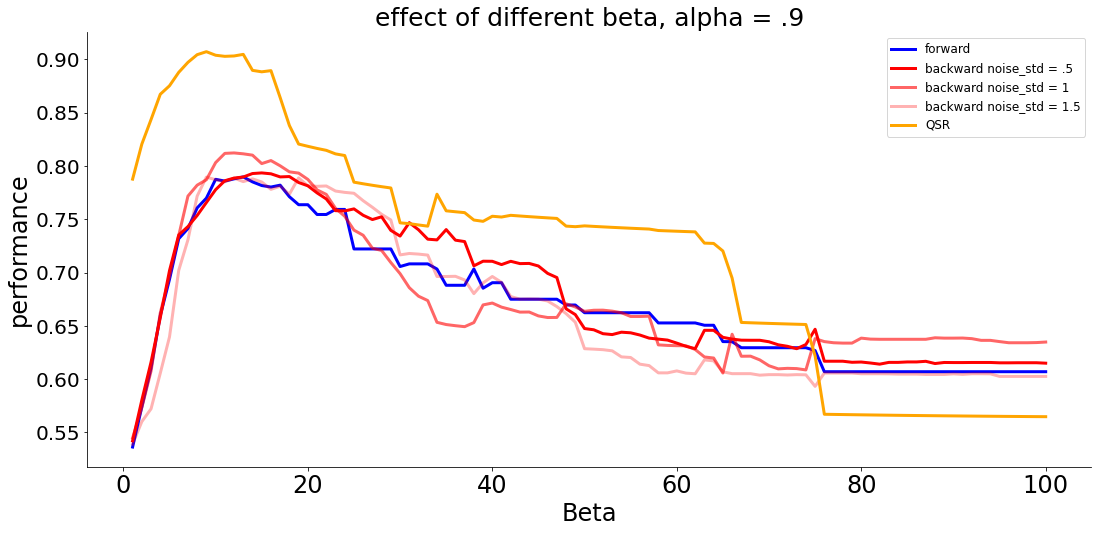

In [170]:
fig, ax = plt.subplots(figsize = (18,8) )

ax.plot(beta_list, forward_perf, color = "blue", lw = 3,label = "forward")
ax.plot(beta_list, backward_perf1, color = "red", lw = 3 , label = "backward noise_std = .5")
ax.plot(beta_list, backward_perf2, color = "red", lw = 3,alpha = .6, label = "backward noise_std = 1")
ax.plot(beta_list, backward_perf3, color = "red", lw = 3,alpha = .3,label = "backward noise_std = 1.5")
ax.plot(beta_list, qsr, color = "orange",label = "QSR" , lw = 3)

plt.title("effect of different beta, alpha = .9" , fontsize=25)
plt.xlabel("Beta", fontsize=24)
plt.ylabel("performance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=12)
plt.show()

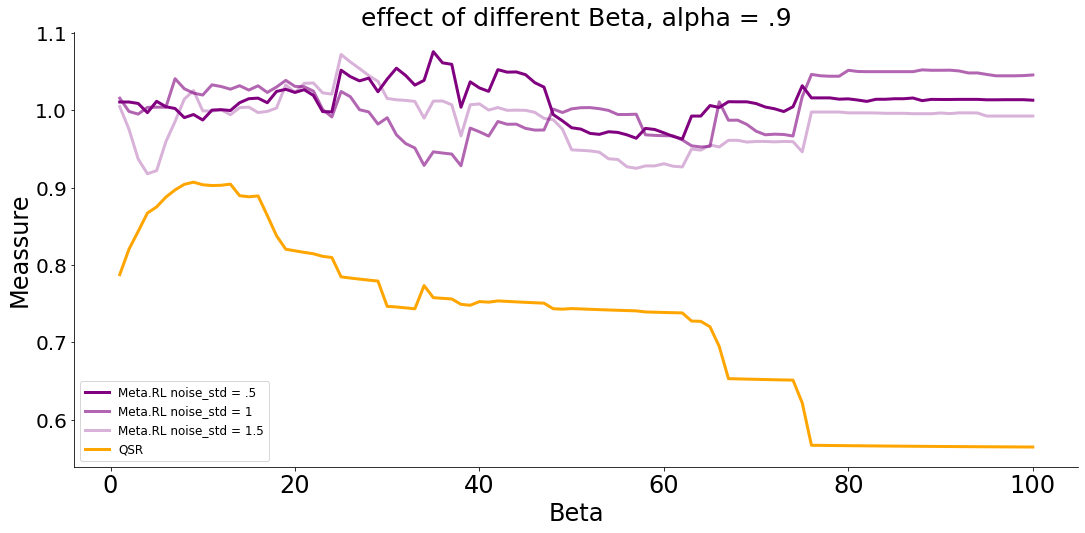

In [171]:
mrl1 = backward_perf1/forward_perf
mrl2 = backward_perf2/forward_perf
mrl3 = backward_perf3/forward_perf

fig, ax = plt.subplots(figsize = (18,8) )

ax.plot(beta_list, mrl1, color = "purple", lw = 3 , label = "Meta.RL noise_std = .5")
ax.plot(beta_list, mrl2, color = "purple", lw = 3,alpha = .6, label = "Meta.RL noise_std = 1")
ax.plot(beta_list, mrl3, color = "purple", lw = 3,alpha = .3,label = "Meta.RL noise_std = 1.5")
ax.plot(beta_list, qsr, color = "orange",label = "QSR" , lw = 3)

plt.title("effect of different Beta, alpha = .9" , fontsize=25)
plt.xlabel("Beta", fontsize=24)
plt.ylabel("Meassure", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=12)
plt.show()